In [1]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pmdarima as pm

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data_hour = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

# Display the last five rows
prices = forex_data_hour['close']
prices

datetime
2024-08-30 06:30:00    2513.13
2024-08-30 06:45:00    2513.59
2024-08-30 07:00:00    2513.63
2024-08-30 07:15:00    2514.57
2024-08-30 07:30:00    2513.42
                        ...   
2024-10-30 17:30:00    2784.01
2024-10-30 17:45:00    2784.74
2024-10-30 18:00:00    2784.93
2024-10-30 18:15:00    2785.42
2024-10-30 18:30:00    2785.82
Name: close, Length: 4000, dtype: float64

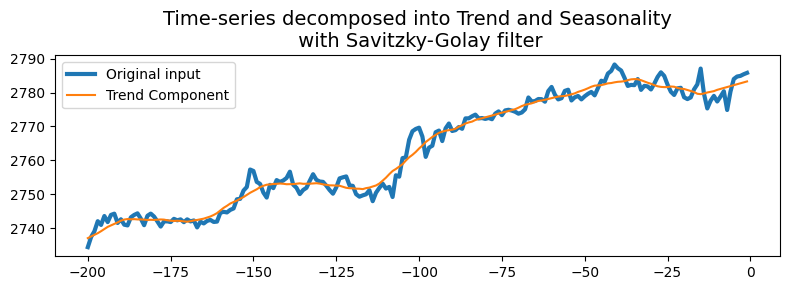

In [2]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()


In [3]:
def fft_forecast(signal, forecast_elements, target_harmonics=40):

    # Perform FFT on the seasonal component
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)

    # **2. Retain non-negative frequencies (including zero)**
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]

    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]

    # **3. Create extended indices including future points**
    reconstructed_length = N + forecast_elements
    extended_indices = np.arange(reconstructed_length)

    # **4. Reconstruct the signal using the selected harmonics**
    reconstructed_signal = np.zeros(reconstructed_length)

    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency

        if frequency == 0:  # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    return reconstructed_signal, num_harmonics

In [15]:
# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [82]:
# Definition of Forecast Parameters
validation_elements = 4
test_elements = 8
seasonal_harmonics_list = [60]
seasonal_input_elements_list = np.arange(200, 800, 10)
#seasonal_input_elements_list = [400]
visualization_elements = 120
shift_step = 12                # Shift each run by 12 data points (3 hours)
num_runs = 50                  # Number of rolling window iterations

# Initialize a list to store results
results = []

for seasonal_harmonics in seasonal_harmonics_list:
    for seasonal_input_elements in seasonal_input_elements_list:
        for run in range(num_runs):
            start_idx = len(yvalues_seasonal) - shift_step*run - test_elements - validation_elements - seasonal_input_elements
            yvalues_seasonal_forecast, num_harmonics = fft_forecast( yvalues_seasonal[start_idx:start_idx+seasonal_input_elements],
                                                                    validation_elements+test_elements,
                                                                    seasonal_harmonics )
        
            # Store the results
            results.append({
                'seasonal_input_length': seasonal_input_elements,
                'seasonal_harmonics': seasonal_harmonics,
                'run': run,
                'rmse_validation': calculate_rmse(yvalues_seasonal[-validation_elements-test_elements:-test_elements], yvalues_seasonal_forecast[-validation_elements-test_elements:-test_elements]),
                'rmse_test': calculate_rmse(yvalues_seasonal[-test_elements:], yvalues_seasonal_forecast[-test_elements:]),
                'rmse_velocity_validation': calculate_rmse(
                    np.diff(yvalues_seasonal[-validation_elements-test_elements-1:-test_elements]),
                    np.diff(yvalues_seasonal_forecast[-validation_elements-test_elements-1:-test_elements])
                ),
                'rmse_velocity_test': calculate_rmse(
                    np.diff(yvalues_seasonal[-test_elements-1:]),
                    np.diff(yvalues_seasonal_forecast[-test_elements-1:])
                )
            })

results_df = pd.DataFrame(results)
print("Mean of RMSE Validation:", results_df['rmse_validation'].mean())
print("Mean of RMSE Test:", results_df['rmse_test'].mean())
r2_value = r2_score(results_df['rmse_validation'], results_df['rmse_test'])
print("R-squared between RMSE Validation and RMSE Test:", r2_value)
pearson_corr = results_df['rmse_validation'].corr(results_df['rmse_test'])
print("Pearson Correlation:", pearson_corr)
r2_value_velocity = r2_score(results_df['rmse_velocity_validation'], results_df['rmse_velocity_test'])
print("R-squared between RMSE Validation and RMSE Test (velocity):", r2_value_velocity)
pearson_corr_velocity = results_df['rmse_velocity_validation'].corr(results_df['rmse_velocity_test'])
print("Pearson Correlation (velocity):", pearson_corr_velocity)
results_df

Mean of RMSE Validation: 2.9589364318279587
Mean of RMSE Test: 3.5817807179127326
R-squared between RMSE Validation and RMSE Test: -0.03569103472679158
Pearson Correlation: 0.4989357311757661
R-squared between RMSE Validation and RMSE Test (velocity): -9.677018089641999
Pearson Correlation (velocity): 0.046337486205578496


,seasonal_input_length,seasonal_harmonics,run,rmse_validation,rmse_test,rmse_velocity_validation,rmse_velocity_test
0,200,60,0,2.182641,3.942637,2.508817,3.280764
1,200,60,1,5.187256,5.616391,0.994658,4.151546
2,200,60,2,1.361323,2.566538,2.768087,2.994830
3,200,60,3,2.446677,3.364376,2.789187,3.237149
4,200,60,4,4.233146,2.830799,3.955958,3.088278
...,...,...,...,...,...,...,...
2995,790,60,45,1.654917,3.133150,1.688668,3.071111
2996,790,60,46,2.322886,2.973281,1.681941,3.037849
2997,790,60,47,2.591374,3.579172,1.619007,3.133287
2998,790,60,48,2.356558,3.284440,1.634777,3.079651


In [77]:
results_df.sort_values(by='rmse_test', ascending=True).head(50)

,seasonal_input_length,seasonal_harmonics,run,rmse_validation,rmse_test,rmse_velocity_validation,rmse_velocity_test
619,320,60,19,3.713902,1.600796,2.267029,2.692246
96,210,60,46,2.230428,1.664234,3.688511,2.457791
56,210,60,6,2.527906,1.675778,1.995683,2.520087
351,270,60,1,2.460648,1.729685,2.354746,2.609948
914,380,60,14,3.628897,1.774511,1.948642,2.811290
187,230,60,37,2.544199,1.777507,2.034811,2.517283
124,220,60,24,1.732645,1.782916,2.043803,2.418022
324,260,60,24,3.875699,1.788210,2.382976,2.891877
867,370,60,17,3.227767,1.833875,1.766024,2.870139
1092,410,60,42,0.888061,1.844436,1.515212,2.839588


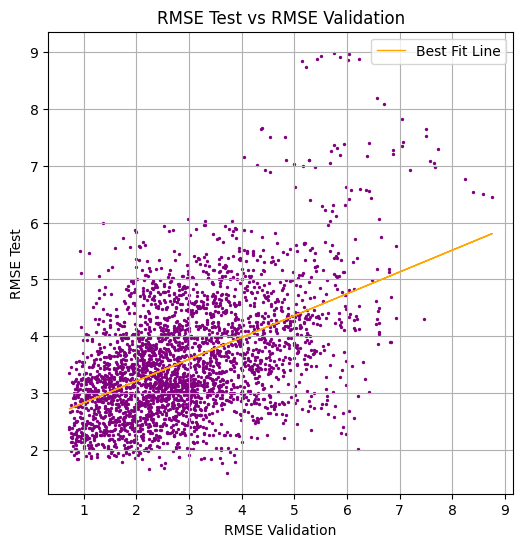

In [51]:
# Scatter plot of RMSE Test against RMSE Validation with smaller dots
plt.figure(figsize=(6, 6))
plt.scatter(results_df['rmse_validation'], results_df['rmse_test'], color='purple', s=2)

# Calculate the best-fit line using numpy's polyfit function
m, b = np.polyfit(results_df['rmse_validation'], results_df['rmse_test'], 1)  # 1st-degree polynomial for linear fit

# Plot the regression line
plt.plot(results_df['rmse_validation'], m * results_df['rmse_validation'] + b, color='orange', linewidth=1, label='Best Fit Line')

# Adding labels, title, and legend
plt.xlabel('RMSE Validation')
plt.ylabel('RMSE Test')
plt.title('RMSE Test vs RMSE Validation')
plt.legend()
plt.grid(True)
plt.show()

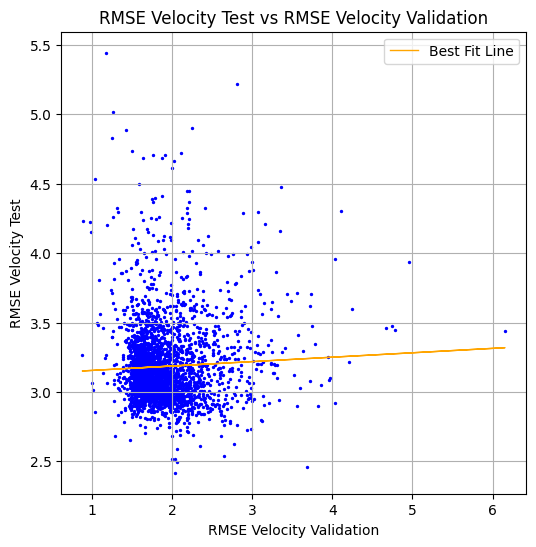

In [78]:
# Scatter plot of RMSE Test against RMSE Validation with smaller dots
plt.figure(figsize=(6, 6))
plt.scatter(results_df['rmse_velocity_validation'], results_df['rmse_velocity_test'], color='blue', s=2)

# Calculate the best-fit line using numpy's polyfit function
m, b = np.polyfit(results_df['rmse_velocity_validation'], results_df['rmse_velocity_test'], 1)  # 1st-degree polynomial for linear fit

# Plot the regression line
plt.plot(results_df['rmse_velocity_validation'], m * results_df['rmse_velocity_validation'] + b, color='orange', linewidth=1, label='Best Fit Line')

# Adding labels, title, and legend
plt.xlabel('RMSE Velocity Validation')
plt.ylabel('RMSE Velocity Test')
plt.title('RMSE Velocity Test vs RMSE Velocity Validation')
plt.legend()
plt.grid(True)
plt.show()

The above plots show the relationship between RMSE Validation and RMSE Test is relatively weak, with an R-squared value of <0.1. This indicates that the relationship between the two variables is not strong enough to draw any meaningful conclusions.

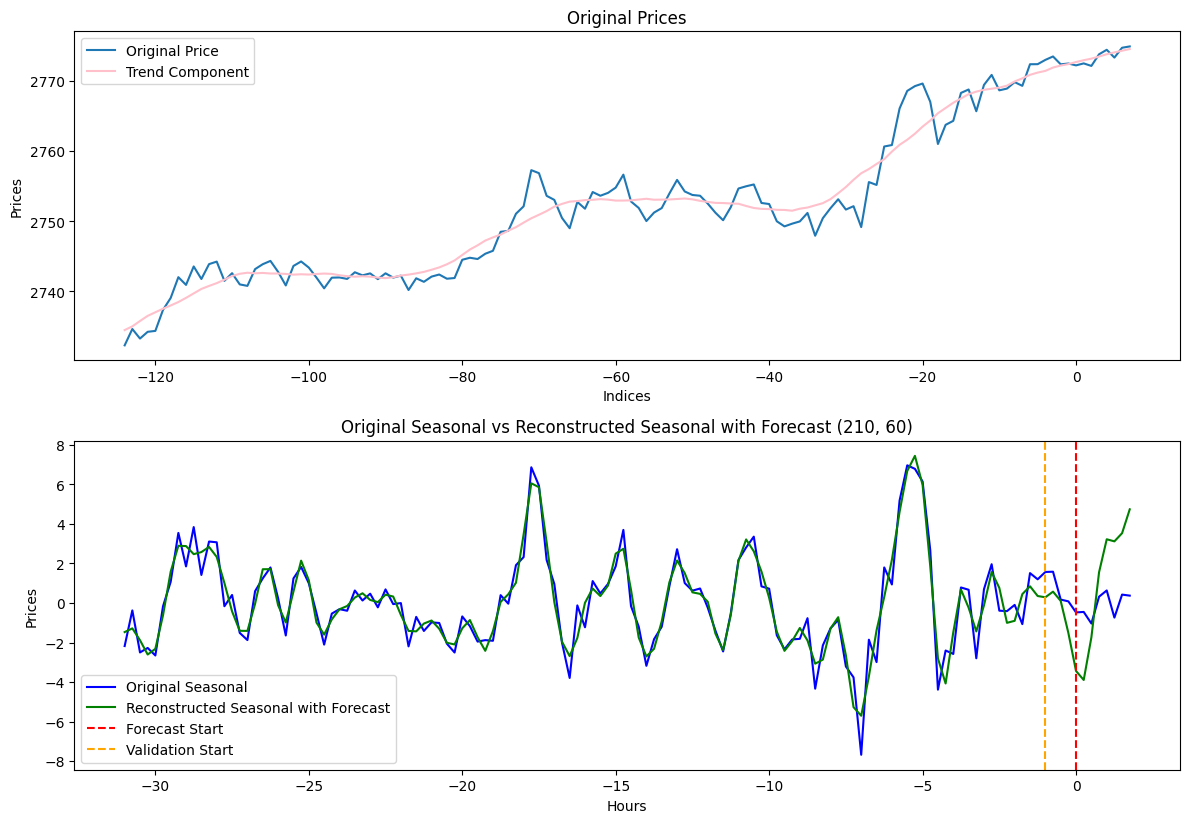

In [81]:
# Plotting for a specific run
seasonal_input_elements = 210
seasonal_harmonics = 60
run = 6
start_idx = len(yvalues_seasonal) - shift_step*run - test_elements - validation_elements - seasonal_input_elements
yvalues_seasonal_forecast, num_harmonics = fft_forecast( yvalues_seasonal[start_idx:start_idx+seasonal_input_elements],
                                                        validation_elements+test_elements,
                                                        seasonal_harmonics )

# Calculate slice indices
len_slice = visualization_elements + validation_elements + test_elements
slice_start_idx = -(shift_step * run + len_slice)
slice_end_idx = -shift_step * run
slice_idx_list = np.arange(-len_slice+test_elements, test_elements)

# Define a helper function for slicing with the condition
def safe_slice(data, start_idx, end_idx):
    return data[start_idx:] if end_idx == 0 else data[start_idx:end_idx]

# Apply the helper function to each slice
prices_slice = safe_slice(prices, slice_start_idx, slice_end_idx)
yvalues_trend_slice = safe_slice(yvalues_trend, slice_start_idx, slice_end_idx)
seasonal_original_slice = safe_slice(yvalues_seasonal, slice_start_idx, slice_end_idx)
seasonal_forecast_slice = yvalues_seasonal_forecast[-len_slice:]



# **6b. Plotting**
plt.figure(figsize=(12, 12))

# Plot original price and trend
plt.subplot(3, 1, 1)
plt.plot(slice_idx_list, prices_slice, label="Original Price")
plt.plot(slice_idx_list, yvalues_trend_slice, label='Trend Component', color='pink')
plt.title("Original Prices")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot original and reconstructed seasonal
plt.subplot(3, 1, 2)
plt.plot(slice_idx_list/4, seasonal_original_slice, label="Original Seasonal", color='blue')
plt.plot(slice_idx_list/4, seasonal_forecast_slice, label="Reconstructed Seasonal with Forecast", color='green')
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.axvline(x=-validation_elements/4, color='orange', linestyle='--', label="Validation Start")
plt.title(f"Original Seasonal vs Reconstructed Seasonal with Forecast ({seasonal_input_elements}, {seasonal_harmonics})")
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()